# Girvan-Newman Benchmark
---
In this exercise we will generate the Girvan-Newman benchmark graph as described in Barabasi's book for multiple values of $\mu$, then we will use the Girvan-Newman algorithm to identify the communities. Then we calculate the information and compare the results from the ones mentioned in the book. <br>
### Girvan-Newman benchmark graph generator

In [169]:
using Graphs, Plots, Colors, Statistics

In [ ]:
function GN_generator(mu)
    #since communities are well connected, we choose a relatively large p_int
    p_int = 0.8
    p_ext = mu * p_int / (1 + mu)
    nc = 4
    Nc = 32
    graph = SimpleGraph(nc * Nc)
    #defining clusters for convinience
    cluster_arr = []
    for i in 1:nc
        cluster = Int[]
        for j in ((i-1) * Nc + 1):((i-1) * Nc + Nc)
            push!(cluster, j)
        end
        push!(cluster_arr, cluster)
    end
    #adding internal edges
    for i in 1:nc
        for j in ((i-1) * Nc + 1):(i * Nc)
            for k in j+1:((i-1) * Nc + Nc)
                if rand()<= p_int
                    add_edge!(graph, j, k)
                end
            end
        end
    end
    #adding external edges
    for i in 1:nc-1
        for j in ((i-1) * Nc + 1):(i * Nc)
            for k in (i * Nc + 1):nc*Nc
                if rand()<= p_ext
                    add_edge!(graph, j, k)
                end
            end
        end
    end
   return graph
end

We hold our communities in a dictionory defined as below:

In [ ]:
function community_table_generator()
    communities_table = Dict()
    Nc = 32
    nc = 4
    for i in 1:nc*Nc
        communities_table[i] = [i]
    end
    return communities_table
end

Now we create a function that generates the similarity matrix for our graph

In [ ]:
function similarity_matrix(g)
    nc = 4
    Nc = 32
    total_nodes = nc * Nc
    adj_matrix = adjacency_matrix(g) #gives values 0 and 1 so we don't need a step function
    degree_arr = degree(g)
    sim_matrix = zeros(total_nodes, total_nodes)
    for i in 1:total_nodes-1
        for j in i+1:total_nodes #we use the similarity amtrix defined in the book
            sim_matrix[i, j] = common_neighbors(g, i, j) / (min(degree_arr[i], degree_arr[j]) + 1 - adj_matrix[i, j])
        end
    end
    return sim_matrix
end

#Function to calculate the common neighbors of two nodes
function common_neighbors(g, i, j)
    i_neighbors = neighbors(g,i)
    j_neighbors = neighbors(g,j)
    common_neighbor_count = length(findall(x->x in i_neighbors, j_neighbors))
    if (j in i_neighbors) || (i in j_neighbors)
        common_neighbor_count = common_neighbor_count + 1
    end
    if i == j
        common_neighbor_count = 0
    end
    return common_neighbor_count
end

Now we create a function to recalculate the similarity matrix for the communities that have formed using our original similarity matrix.

In [ ]:
function similarity_matrix_recalc(sim_mat_org, com_dict, sim_mat_org_org)
    community_arr = sort(unique(collect(keys(com_dict))))
    community_num = length(community_arr)
    new_sim_mat = zeros(community_num, community_num)
    for i in 1:community_num-1
        for j in i+1:community_num
            new_sim_mat[i, j] = community_average(sim_mat_org_org, com_dict[community_arr[i]], com_dict[community_arr[j]])
        end
    end
    return new_sim_mat
end

function community_average(mat, arr1, arr2)
    sum = 0
    for i in arr1
        for j in arr2
            sum = sum + mat[i, j]
        end
    end
    avg = sum / (length(arr1) * length(arr2))
    return avg
end

Now we need a function that merges two communities which have the highest similarity and returns the new community table

In [ ]:
function community_merge_step(sim_mat, com_dict)
    community_arr = sort(collect(keys(com_dict)))
    max, indexes = findmax(sim_mat)
    min_index = min(indexes[1], indexes[2])
    max_index = maximum([indexes[1], indexes[2]])
    min_index_vals = com_dict[community_arr[min_index]]
    max_index_vals = com_dict[community_arr[max_index]]
    new_com_val = unique(vcat(min_index_vals, max_index_vals))
    com_dict[community_arr[min_index]] = new_com_val
    delete!(com_dict, community_arr[max_index])
    return com_dict
end

Now to find the accuracy we define the function below which shows the inaccuracy in percentages

In [ ]:
function accuracy(set_arr)
    set1 = floor.(Int, LinRange(1, 32, 32))
    set2 = floor.(Int, LinRange(33, 64, 32))
    set3 = floor.(Int, LinRange(65, 96, 32))
    set4 = floor.(Int, LinRange(97, 128, 32))
    diff = length(setdiff(set_arr[1], set1)) + length(setdiff(set_arr[2], set2)) + length(setdiff(set_arr[3], set3)) + length(setdiff(set_arr[4], set4))
    return 100 - (diff/180) * 100
end

Now we perform the steps until only four communities remain. We also calculate the accuracy according to the accuracy we defined. (We also average over 100 runs)

In [ ]:
mu_arr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
accuracy_results = Float64[]
for mu in mu_arr
    accuracy_arr = Float64[]
    for k in 1:100
        results = []
        GN_benchmark = GN_generator(mu)
        community_table = community_table_generator()
        sim_mat_org = similarity_matrix(GN_benchmark)
        sim_mat = sim_mat_org
        for i in 1:124
            community_table = community_merge_step(sim_mat, community_table)
            sim_mat = similarity_matrix_recalc(sim_mat, community_table, sim_mat_org)
        end
        val = collect(values(community_table))
        for i in 1:4
            val[i] = Set(val[i])
        end
        push!(results, val)
        for i in 1:length(results)
            push!(accuracy_arr, accuracy(results[i]))
        end
    end
    push!(accuracy_results, mean(accuracy_arr))
end

accuracy_results

Now we plot the accuracy against $\mu$

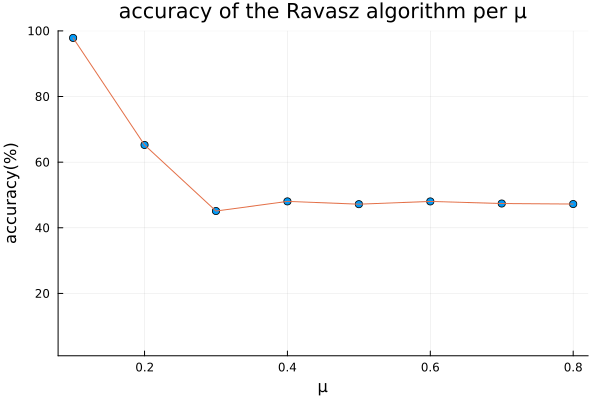

In [178]:
Plots.scatter(mu_arr, accuracy_results, ylims = (1,100), title = "accuracy of the Ravasz algorithm per μ", xlabel = "μ", ylabel = "accuracy(%)", legend = false)
Plots.plot!(mu_arr, accuracy_results)

As expected with the increase of $\mu$, the accuracy of our method drops but remains decently accurate for large $\mu$ s. In the graph in the book, the accuracy remains higher for small $\mu$ s, but that graph uses a different metric to gauge the accuracy of the algorithm. Overall we have been able to build the benchmark graph and identify it's communities using the Ravasz algorithm successfully from scratch.